In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'xarray'

<xarray.Dataset> Size: 60kB
Dimensions:      (depth_index: 579, doy: 12)
Coordinates:
  * depth_index  (depth_index) int64 5kB 1 2 3 4 5 6 ... 574 575 576 577 578 579
  * doy          (doy) float64 96B 15.0 45.0 75.0 105.0 ... 285.0 315.0 345.0
Data variables:
    temp_c       (depth_index, doy) float64 56kB ...

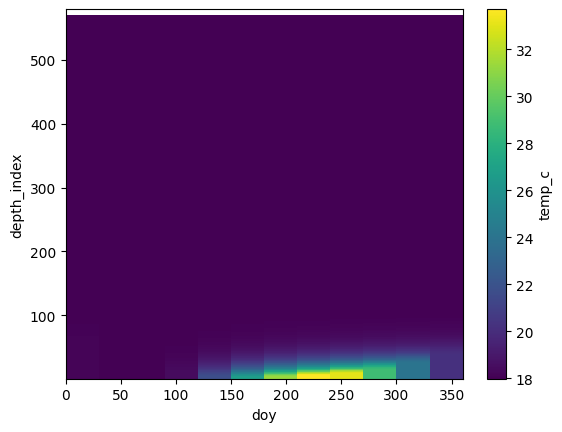

In [4]:
# Load lake data
lakedata =  xr.open_dataset('_test_prof (1).nc')
lakedata['temp_c'].plot()
lakedata

In [5]:
timesteps = lakedata['doy'].values # 1D array of days of year
print(timesteps)






[ 15.  45.  75. 105. 135. 165. 195. 225. 255. 285. 315. 345.]


In [1]:
timesteps = lakedata['doy'].values
depths = np.array(lakedata['depth_cm'])
wtdmean_cap47_list, wtdmean_temp_list = [], []  # hold weighted mean values
for ts in timesteps:
    tmpds = lakedata.sel(doy = ts) # pull out this timestep
    tmpdf = tmpds.to_dataframe().reset_index()  # convert it to pandas df
    
    def clumped_sensor(tmpdf, T_C, model='I-CDES90'):
        if model == 'I-CDES90':
            Cap47 = 0.0004 * 10**6 / (T_C + 273.15)**2 + 0.154 # Anderson et al 2021 I-CDES90 ref frame (w/ conversion from Celcius to Kelvin) # not including +/- uncertainties, can add later
        elif model == 'CDES90': 
            Cap47 = 1  # will add other functions
        else:
            raise ValueError("Model not recognized")
        return Cap47 # returns model eq back to caller (clumped_sensor)
    




NameError: name 'lakedata' is not defined

In [ ]:

depths = np.array(lakedata['depth_cm'])

def generate_weights(depths, weight_type, weight_dict): #add so that it adds weights to doy too based off notes (for loop?)
    """
    Generate a depth-weighting function.

    Args:
        depths (np.ndarray or pd.Series): Array or DataFrame column of depth values.
        weight_type (str): Equation type for computing the weighting with depth.

    Returns:
        np.ndarray: Array of weights aligned with the depth values.
    """
    if weight_type == "uniform":
        weights = np.repeat(1 / len(depths), len(depths))
       
    elif weight_type == "surface":
        weights = np.array([1] + [0] * (len(depths) - 1))
       
    elif weight_type == "normal_dist":
        depth_cm_mean = round(lakedata['depth_cm'].values.mean(), 2)
        depth_cm_std = round(lakedata['depth_cm'].values.std(), 2)
        weights = (1 / (depth_cm_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((depths - depth_cm_mean) / depth_cm_std) ** 2)
        # Normalize the weights so they sum to 1
        weights /= weights.sum()
    else:
        raise ValueError("Weight type not recognized")
    
    return weights
    
    
    
    
    
    cap47, depth_weights, doy_weights, wtd_mean_cap47, wtd_mean_temp = haileys_fun(tmpdf, args...)
    # [ returns: cap47 per depth, wts, wtd mean ]
    # ---

    # pseudocode...
    # wtdmean_cap47_list.append(wtd_mean_cap47)
    # wtdmean_temp_list.append(wtd_mean_temp)

    # if ts == timesteps[0]:
        # cap47_out = cap47.copy()
        # wts_out = wts.copy()
    # else:
        # cap47_out = pd.concat([cap47_out, cap47])
        # wts_out = pd.concat([wts_out, cap47])


# TODO --- 
# - weight the wtdmean_*_list over time based on the time weights
#   (could do this in `haileys_fun` as well!)
# - add to dataset as variable that's not defined over depth nor time
# ---


# [outside of the for-loop]    
# add dataframes as variables to the dataset...
# Convert DataFrame to xarray Dataset
wts_ds = wts_out.set_index(["depth_index", "doy"]).to_xarray()
cap47_ds = cap47_out.set_index(["depth_index", "doy"]).to_xarray()

# Merge with existing Dataset
merged_ds = xr.merge([ds, wts_ds, cap47_ds])

# add the weights variable (defined only over time)
merged_ds["temp_wtmean"] = xr.DataArray(wtdmean_temp_list, coords={"doy": ds.doy}, dims="doy")
merged_ds["cap47_wtmean"] = xr.DataArray(wtdmean_cap47_list, coords={"doy": ds.doy}, dims="doy")

# return results
# return merged_ds

In [ ]:
tmpdf = tmpds.to_dataframe().reset_index()
tmpdf = tmpdf.rename(columns = {"temp_c": "weight"}).copy()

ds_test = tmpdf.set_index(["depth_index", "doy"]).to_xarray()
ds_test
xr.merge([ds, ds_test])

In [ ]:
ds
# add variable for weighted mean that's only defined over doy
# add variable for weights that's defined over depth and doy
# add variable for cap47 that's defined over depth and doy

In [8]:
lakedata.isel(doy=0) #selects first index in doy

<xarray.Dataset> Size: 9kB
Dimensions:      (depth_index: 579)
Coordinates:
  * depth_index  (depth_index) int64 5kB 1 2 3 4 5 6 ... 574 575 576 577 578 579
    doy          float64 8B 15.0
Data variables:
    temp_c       (depth_index) float64 5kB ...

In [3]:
# Load lake data
lakedata = pd.read_csv('lake_data.csv') # OLD
lakedata_df = pd.DataFrame(lakedata)
display(lakedata_df)

NameError: name 'pd' is not defined

In [4]:
# Calculate mean & stdev for depth and temperature columns
def generate_statistics(lakedata): 
    stats = { 'depth_cm_mean': round(lakedata['depth_cm'].values.mean(), 2), 
             'depth_cm_std': round(lakedata['depth_cm'].values.std(), 2),
             'T_C_mean': round(lakedata['T_C'].values.mean(), 2),
             'T_C_std': round(lakedata['T_C'].values.std(), 2)
            }
    return stats 

statistics = generate_statistics(lakedata) 
statistics_df = pd.DataFrame([statistics])
statistics = xr.Dataset.from_dataframe(statistics_df)
statistics

# Create weight_dict with the statistics (parameters for the normal_dist weighting function)
weight_dict = {
    'depth_cm_mean': statistics['depth_cm_mean'].values[0],
    'depth_cm_std': statistics['depth_cm_std'].values[0],
    'T_C_mean': statistics['T_C_mean'].values[0],
    'T_C_std': statistics['T_C_std'].values[0]}

weight_dict


{'depth_cm_mean': np.float64(188.6),
 'depth_cm_std': np.float64(307.79),
 'T_C_mean': np.float64(15.0),
 'T_C_std': np.float64(10.85)}

In [7]:
depths = np.array(lakedata['depth_cm'])

def generate_weights(depths, weight_type, weight_dict):
    """
    Generate a depth-weighting function.

    Args:
        depths (np.ndarray or pd.Series): Array or DataFrame column of depth values.
        weight_type (str): Equation type for computing the weighting with depth.
        weight_dict (dict): Dictionary of input parameter values for the weighting equation.

    Returns:
        np.ndarray: Array of weights aligned with the depth values.
    """
    if weight_type == "uniform":
        weights = np.repeat(1 / len(depths), len(depths))
       
    elif weight_type == "surface":
        weights = np.array([1] + [0] * (len(depths) - 1))
       
    elif weight_type == "normal_dist":
        depth_cm_mean = weight_dict["depth_cm_mean"]
        depth_cm_std = weight_dict["depth_cm_std"]
        weights = (1 / (depth_cm_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((depths - depth_cm_mean) / depth_cm_std) ** 2)
        # Normalize the weights so they sum to 1
        weights /= weights.sum()
    else:
        raise ValueError("Weight type not recognized")
    # Add more conditions for other weight types if needed

    return weights

In [2]:
# Calculate Cap47 at each depth and add it to lakedata_df
lakedata_df['Cap47'] = lakedata_df['T_C'].apply(clumped_sensor)

# Calculate Cap47 weights
lakedata_df['weights'] = generate_weights(depths, "normal_dist", weight_dict)

# Calculate weighted mean of Cap47 for water column
Cap47_wtd_mean = (lakedata_df['Cap47'] * lakedata_df['weights']).sum() / len(lakedata_df)
T_C_wtd_mean = (lakedata_df['T_C'] * lakedata_df['weights']).sum() / len(lakedata_df)
display(lakedata_df)
print(f"Cap47_wtd_mean = {Cap47_wtd_mean}")

NameError: name 'lakedata_df' is not defined

In [ ]:

import pandas as pd
import xarray as xr

# Load the netCDF file
ds = xr.open_dataset('_test_prof (1).nc')

# Convert to DataFrame
df = ds.to_dataframe()

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(df)


                   temp_c
depth_index doy          
1           15.0   18.107
            45.0   17.990
            75.0   17.990
            105.0  18.428
            135.0  21.685
            165.0  26.726
            195.0  31.303
            225.0  33.713
            255.0  33.060
            285.0  28.853
            315.0  24.041
            345.0  20.151
2           15.0   18.107
            45.0   17.990
            75.0   17.990
            105.0  18.428
            135.0  21.685
            165.0  26.726
            195.0  31.303
            225.0  33.713
            255.0  33.060
            285.0  28.853
            315.0  24.041
            345.0  20.151
3           15.0   18.107
            45.0   17.990
            75.0   17.990
            105.0  18.428
            135.0  21.685
            165.0  26.726
            195.0  31.303
            225.0  33.713
            255.0  33.060
            285.0  28.853
            315.0  24.041
            345.0  20.151
4           